# Xray Tomography

[![Open In Colab](https://img.shields.io/badge/open%20in-Colab-b5e2fa?logo=googlecolab&style=flat-square&color=ffd670)](https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/examples/xray_tomography/xray_tomography.ipynb)

> If you are running this notebook locally, make sure you've followed [steps here](https://github.com/inlab-geo/cofi-examples#run-the-examples-with-cofi-locally)
to set up the environment. (This [environment.yml](https://github.com/inlab-geo/cofi-examples/blob/main/envs/environment.yml) file
specifies a list of packages required to run the notebooks)

*Adapted from notebooks by Andrew Valentine & Malcolm Sambridge - Research School of Earth Sciences, The Australian National University*

In this notebook, we look at an linear inverse problem based on Xray Tomography. 
We will use `cofi` to run a linear system solver (optionally with Tikhonov regularization 
and noise estimation) for this problem.

## 0. Import modules

The package `geo-espresso` contains the forward code for this problem.

In [1]:
# -------------------------------------------------------- #
#                                                          #
#     Uncomment below to set up environment on "colab"     #
#                                                          #
# -------------------------------------------------------- #

# !pip install -U cofi geo-espresso
# !git clone https://github.com/inlab-geo/cofi-examples.git
# %cd cofi-examples/examples/xray_tomography

In [1]:
import numpy as np
from cofi import BaseProblem, InversionOptions, Inversion
from cofi.utils import QuadraticReg
from espresso import XrayTomography

## 1. Define the problem

In [2]:
# display theory on the inference problem
from IPython.display import display, Markdown

with open("../../theory/geo_xray_tomography.md", "r") as f:
    content = f.read()

display(Markdown(content))

As an example, we will consider performing X-Ray Tomography (XRT) to image the interior of a structure. 

We assume that the x-rays travel at the same speed regardless of the medium through which they are passing, and so their paths are straight lines between source and receiver. However, the medium causes the x-rays to attenuate: paths through dense objects (such as bones!) arrive at the receiver with far less energy than they had at the source. Thus, by analysing the attenuation along many different paths, we can build up a picture of the interior of an object.

Specifically, we will assume that the intensity at the receiver, $I_{rec}$, is related to the intensity at the source, $I_{src}$ by $$I_{rec} = I_{src}\exp\left\{-\int_\mathrm{path} \mu(\mathbf{x})\,\mathrm{d}\mathbf{l}\right\}$$ where $\mu(\mathbf{x})$ is a position-dependent attenuation coefficient. To obtain a linear inverse problem, we rewrite this as $$-\log \frac{I_{rec}}{I_{src}}=\int_\mathrm{path} \mu(\mathbf{x})\,\mathrm{d}\mathbf{l}\,.$$ We know that $$\int\left[f(x) + g(x)\right]\,\mathrm{d}x = \int f(x)\,\mathrm{d}x + \int g(x)\,\mathrm{d}x$$ so we say that integration is a *linear* operation, and hence we can solve the XRT problem with linear inverse theory. 

We will assume that the object we are interested in is 2-dimensional, so that $\mu(\boldsymbol{x}) = \mu(x,y)$. If we discretize this model, with $N_x$ cells in the $x$-direction and $N_y$ cells in the $y$-direction, we can express $\mu(x,y)$ as an $N_x \times N_y$ vector $\boldsymbol{\mu}$. This is related to the data by
$$d_i = A_{ij}\mu_j$$
where $d_i = -\log {I^{(i)}_{rec}}/{I^{(i)}_{src}}$, and where $A_{ij}$ represents the path length in cell $j$ of the discretized model.


Firstly, we get some information from the `geo-espresso` module.
These include the dataset and the Jacobian matrix. In the Xray
Tomography example, the Jacobian matrix is related to the lengths
of paths within each grid. Since the paths are fixed, the Jacobian
matrix stays constant.

In [3]:
xrt = XrayTomography()

In [4]:
xrt_problem = BaseProblem()
xrt_problem.set_data(xrt.data)
xrt_problem.set_jacobian(xrt.jacobian(xrt.starting_model))

Evaluating paths: 100%|██████████████████████████████████████████████████████████████████████████████| 10416/10416 [00:00<00:00, 15269.14it/s]


Evaluating paths:   9%|████████████████▍                                                                                                                                                                          | 913/10416 [00:00<00:01, 9123.07it/s]

Evaluating paths:  18%|█████████████████████████████████▍                                                                                                                                                        | 1871/10416 [00:00<00:00, 9390.76it/s]

Evaluating paths:  27%|██████████████████████████████████████████████████▏                                                                                                                                       | 2813/10416 [00:00<00:00, 9403.02it/s]

Evaluating paths:  36%|███████████████████████████████████████████████████████████████████▏                                                                                                                      | 3761/10416 [00:00<00:00, 9426.29it/s]

Evaluating paths:  45%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 4720/10416 [00:00<00:00, 9482.01it/s]

Evaluating paths:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 5669/10416 [00:00<00:00, 9469.83it/s]

Evaluating paths:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 6625/10416 [00:00<00:00, 9496.23it/s]

Evaluating paths:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 7575/10416 [00:00<00:00, 9478.73it/s]

Evaluating paths:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 8523/10416 [00:00<00:00, 9445.58it/s]

Evaluating paths:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 9479/10416 [00:01<00:00, 9479.57it/s]

Evaluating paths: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10416/10416 [00:01<00:00, 9470.44it/s]

We do some estimation on data noise and further perform a regularization.

In [5]:
sigma = 0.002
lamda = 50
data_cov_inv = np.identity(xrt.data_size) * (1/sigma**2)

In [6]:
xrt_problem.set_data_covariance_inv(data_cov_inv)
xrt_problem.set_regularization(lamda * QuadraticReg(model_shape=(xrt.model_size,)))

Review what information is included in the `BaseProblem` object:

In [7]:
xrt_problem.summary()

Summary for inversion problem: BaseProblem
Model shape: Unknown
---------------------------------------------------------------------
List of functions/properties set by you:
['jacobian', 'regularization', 'data', 'data_covariance_inv']
---------------------------------------------------------------------
List of functions/properties created based on what you have provided:
['jacobian_times_vector']
---------------------------------------------------------------------
List of functions/properties that can be further set for the problem:
( not all of these may be relevant to your inversion workflow )
['objective', 'log_posterior', 'log_posterior_with_blobs', 'log_likelihood', 'log_prior', 'gradient', 'hessian', 'hessian_times_vector', 'residual', 'jacobian_times_vector', 'data_misfit', 'regularization_matrix', 'forward', 'data_covariance', 'initial_model', 'model_shape', 'blobs_dtype', 'bounds', 'constraints']


## 2. Define the inversion options

In [8]:
my_options = InversionOptions()
my_options.set_tool("scipy.linalg.lstsq")

Review what's been defined for the inversion we are about to run:

In [9]:
my_options.summary()

Summary for inversion options
Solving method: None set
Use `suggest_solving_methods()` to check available solving methods.
-----------------------------
Backend tool: `<class 'cofi.tools._scipy_lstsq.ScipyLstSq'>` - SciPy's wrapper function over LAPACK's linear least-squares solver, using 'gelsd', 'gelsy' (default), or 'gelss' as backend driver
References: ['https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.lstsq.html', 'https://www.netlib.org/lapack/lug/node27.html']
Use `suggest_tools()` to check available backend tools.
-----------------------------
Solver-specific parameters: None set
Use `suggest_solver_params()` to check required/optional solver-specific parameters.


## 3. Start an inversion

We can now solve the inverse problem using the Tikhonov-regularized form of least-squares,
$$\mathbf{m}=\left(\mathbf{A^TA}+\epsilon^2\sigma^2\mathbf{I}\right)^\mathbf{-1}\mathbf{A^Td}$$
where $\sigma^2$ is the variance of the expected noise on the attenuation data.

For this dataset, we've taken $\sigma = 0.002$s and chosen $\epsilon^2 = 50$. 

In [10]:
inv = Inversion(xrt_problem, my_options)
inv_result = inv.run()
inv_result.summary()

Summary for inversion result
SUCCESS
----------------------------
model: [0.98494811 1.03000048 0.95776419 ... 0.94168322 1.03668701 1.00048943]
sum_of_squared_residuals: []
effective_rank: 2500
singular_values: [9.30139732e+05 8.57631566e+05 8.57631566e+05 ... 1.14515274e+03
 8.80600410e+02 8.80600410e+02]
model_covariance: [[ 1.17571588e-04 -8.57198189e-05 -1.62727362e-06 ...  1.56635037e-07
  -6.08653282e-08 -1.36217397e-07]
 [-8.57198189e-05  2.14596891e-04 -5.56362665e-05 ... -6.06195208e-07
   4.87748993e-07 -6.08653282e-08]
 [-1.62727362e-06 -5.56362665e-05  1.35540260e-04 ...  5.04358068e-07
  -6.06195208e-07  1.56635037e-07]
 ...
 [ 1.56635037e-07 -6.06195208e-07  5.04358068e-07 ...  1.35540260e-04
  -5.56362665e-05 -1.62727362e-06]
 [-6.08653282e-08  4.87748993e-07 -6.06195208e-07 ... -5.56362665e-05
   2.14596891e-04 -8.57198189e-05]
 [-1.36217397e-07 -6.08653282e-08  1.56635037e-07 ... -1.62727362e-06
  -8.57198189e-05  1.17571588e-04]]


## 4. Plotting

Below the two figures refers to the inferred model and true model respectively.

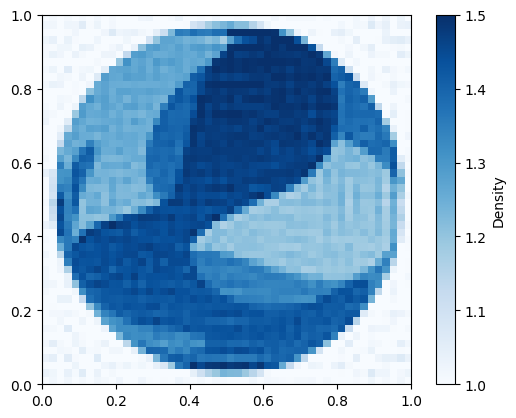

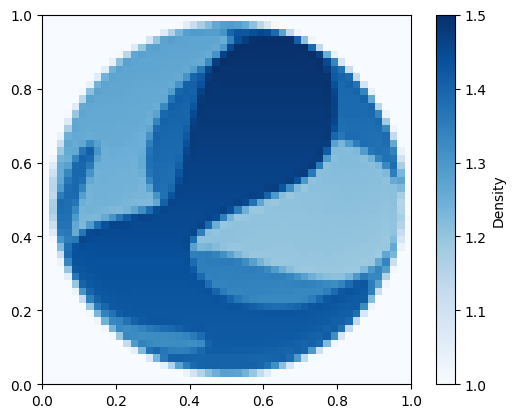

In [11]:
xrt.plot_model(inv_result.model, clim=(1, 1.5));       # inferred model
xrt.plot_model(xrt.good_model, clim=(1, 1.5));          # true model

## 5. Estimated uncertainties

We can now find the uncertainty on the recovered slowness parameters, which describes how noise in the data propagate into the
slowness parameters with this data set. For the Tikhonov-regularised form of least-squares, the model covariance matrix is a square
matrix of size $M\times M$, where there are $M$ cells in the model.

$$\mathbf{C_m}=\sigma^2\left(\mathbf{A^TA}+\epsilon^2\sigma^2\mathbf{I}\right)^\mathbf{-1}$$.

This matrix was calculated as part of the solver routine above. The square roots of the diagonal entries of this matrix are the $\sigma$ errors in the slowness in each cell.

In [12]:
Cm = inv_result.model_covariance

Lets plot the slowness uncertainties as a function of position across the cellular model.

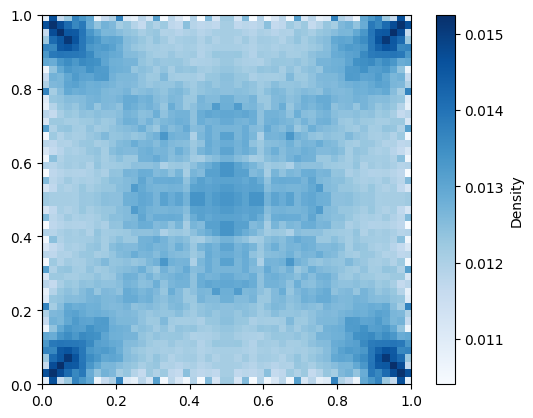

In [13]:
xrt.plot_model(np.sqrt(np.diag(Cm)));

Uncertainty is uniformly low across the entire model and only significant near the corners where there are few ray paths.

Similarly we can calculate uncertainty in velocity parameters using some calculus.
$$ \Delta v = \left | \frac{\partial s}{\partial v}  \right | \Delta s $$
and since $s = 1/v$ we get
$$ \Delta v = s^2\Delta s $$
which gives the uncertainty image on velocity, which looks very similar.

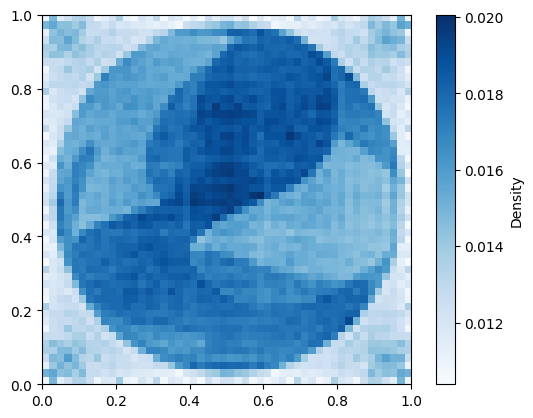

In [14]:
xrt.plot_model(np.sqrt(np.diag(Cm)) * inv_result.model);

By clipping the colour range you can see an imprint of the true image, indicating that high slowness/low velcoity areas have slightly higher uncertainty.

---
## Watermark

<!-- Feel free to add more modules in the watermark_list below, if more packages are used -->
<!-- Otherwise please leave the below code cell unchanged -->

In [15]:
watermark_list = ["cofi", "espresso", "numpy", "scipy", "matplotlib"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))

cofi 0.2.9
espresso 0.3.19
numpy 2.2.3
scipy 1.15.2
matplotlib 3.10.1
